In [25]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from mmpose.codecs import UDPHeatmap

from models.PoseEstimate import PoseEstimate
from models.backbone import ResNet50, ViTEncoder, VideoViTEncoder, FusionVit
from models.neck import UnPatch
from models.head import DeconvHead, MaskHead, ResMaskHead, SimpleHead

from datasets import PoseTrack21
from utilities.utilities import keypoint_info, skeleton_info, keypoints_to_label_flag, HiddenPrints, get_pred_heatmap_mask, heatmaps_to_keypoints

In [2]:
def rescale_color(color):
    return list(map(lambda x: x/255, color))

keypoint_name_to_id_map = {
    "nose": 0,
    "head_bottom": 1,
    "head_top": 2,
    "left_ear": 3,
    "right_ear": 4,
    "left_shoulder": 5,
    "right_shoulder": 6,
    "left_elbow": 7,
    "right_elbow": 8,
    "left_wrist": 9,
    "right_wrist": 10,
    "left_hip": 11,
    "right_hip": 12,
    "left_knee": 13,
    "right_knee": 14,
    "left_ankle": 15,
    "right_ankle": 16
}

In [61]:
def plot_pose_single(image, keypoints, mask, show_ax=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 10))
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()
    ax.imshow(image)
    if not show_ax:
        ax.axis('off')
    for i, (x, y) in enumerate(keypoints):
        if mask[i]:
            ax.scatter(x, y, color=rescale_color(keypoint_info[i]["color"]))
    # plot skeleton
    for info in skeleton_info:
        keypoint_id_1 = keypoint_name_to_id_map[info["link"][0]]
        keypoint_id_2 = keypoint_name_to_id_map[info["link"][1]]
        if mask[keypoint_id_1] and mask[keypoint_id_2]:
            x1, y1 = keypoints[keypoint_id_1]
            x2, y2 = keypoints[keypoint_id_2]
            ax.plot([x1, x2], [y1, y2], color=rescale_color(info["color"]))
    if ax is None:
        plt.show()

In [4]:
dataset_root_dir = "/home/junfeng/datasets/PoseTrack21"
dataset_train = PoseTrack21(
    root_dir=dataset_root_dir,
    set="train",
)

dataset_test = PoseTrack21(
    root_dir=dataset_root_dir,
    set="test",
)

print(len(dataset_train))
print(len(dataset_test))

593
170


In [43]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
pretrained_path = "./checkpoints/vitpose_base_coco_aic_mpii.pth"
encoder = FusionVit(pretrained_path=pretrained_path)
neck = nn.Identity()
head = DeconvHead(pretrained_path=pretrained_path)
model = PoseEstimate(encoder=encoder, neck=neck, head=head)
model.to(device)
model_path = "./checkpoints/Fusion_Deconv_Best_02.pth"
model_dict = torch.load(model_path, map_location="cpu")
model.load_state_dict(model_dict["model_state_dict"])
epoch = model_dict["epoch"]
print(f"Loaded model from {model_path} at epoch {epoch}")
with HiddenPrints():
    model.to(device)
    model.eval()

Loaded model from ./checkpoints/Fusion_Deconv_Best_02.pth at epoch 1600


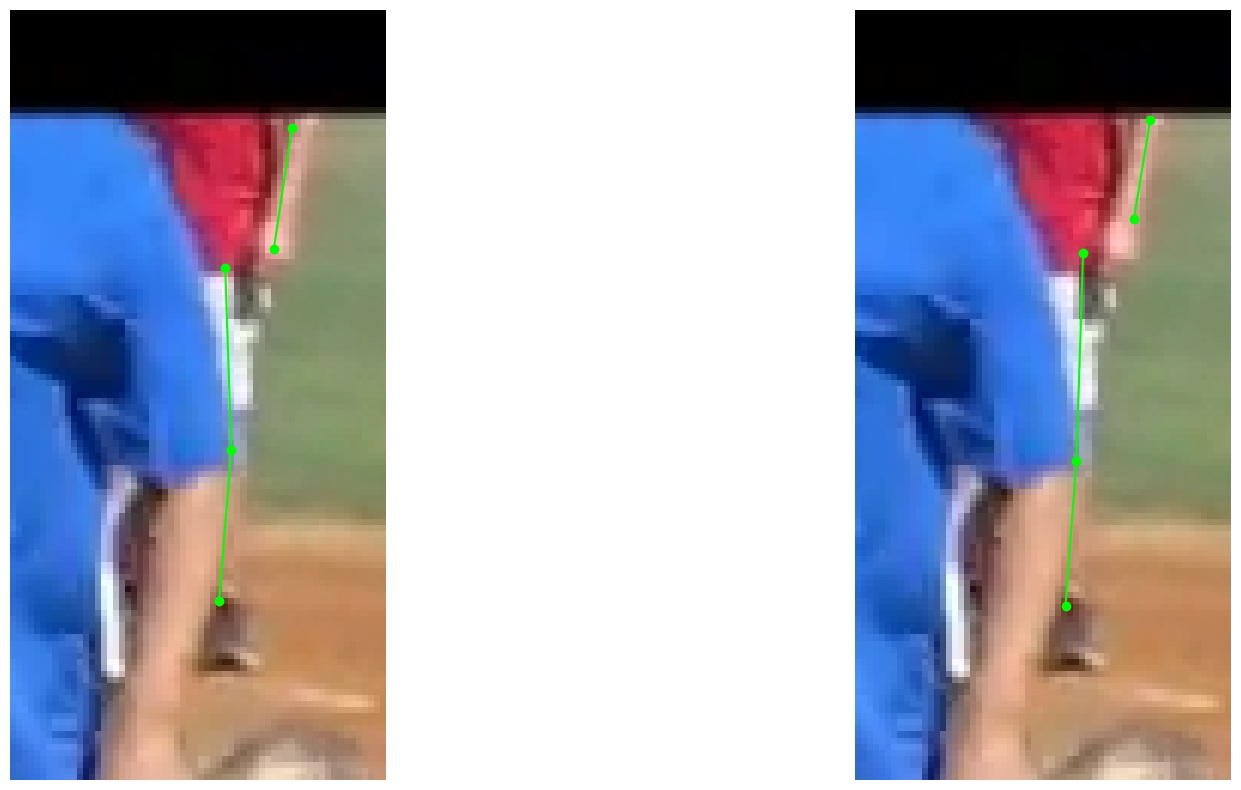

In [65]:
dataset = dataset_test
random_idx = np.random.randint(0, len(dataset))
video, video_transformed, keypoints, keypoints_transformed, heatmaps = dataset[random_idx]
image = video[1]
H, W, _ = image.shape
image_transformed = video_transformed[1]
mask = keypoints_to_label_flag(keypoints_transformed).reshape(-1)
udp = UDPHeatmap(input_size=(W, H), heatmap_size=(48, 64))
pred_heatmaps = model(video_transformed.unsqueeze(0).to(device)).squeeze(0).cpu().detach().numpy()
pred_mask = get_pred_heatmap_mask(pred_heatmaps).reshape(-1)
pred_keypoints = udp.decode(pred_heatmaps)[0][0]
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
plot_pose_single(image, keypoints[:, :2], mask, ax=ax[0])
plot_pose_single(image, pred_keypoints, pred_mask, ax=ax[1])
plt.show()